In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm

from graph import _get_genes, _get_phenotypes, _get_positive_negative_edges, _load_gen_df, _load_phn_df, _merge_dfs

/home/mkoziarski/miniconda3/envs/sg/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
fig_path = Path('figures')
fig_path.mkdir(exist_ok=True, parents=True)

In [3]:
dfs = []

for i in tqdm(range(100)):
    df = pd.read_csv(f'results_multiseed/results_{i}.csv')
    dfs.append(df)

df = pd.concat(dfs).groupby(['Gen', 'Phn']).agg('mean').reset_index()
df

  0%|          | 0/100 [00:00<?, ?it/s]

,Gen,Phn,p
0,A1CF,C1007,0.087234
1,A1CF,C1010,0.035111
2,A1CF,C1052,0.070773
3,A1CF,C1067,0.016427
4,A1CF,C1068,0.016052
...,...,...,...
899635,sep-15,L2003,0.001718
899636,sep-15,L2004,0.001608
899637,sep-15,L2005,0.003763
899638,sep-15,L2006,0.002171


In [4]:
df_gen = _load_gen_df()
df_phn = _load_phn_df()

genes = _get_genes(df_gen, df_phn)
phenotypes = _get_phenotypes(df_phn)

positive_edges, _ = _get_positive_negative_edges(_merge_dfs(df_gen, df_phn), genes, phenotypes)
positive_edges = pd.DataFrame({'Gen': positive_edges['Nod_B'], 'Phn': positive_edges['Nod_A'], 'GT': 1})
positive_edges

,Gen,Phn,GT
0,MAP3K4-AS1,D1071,1
1,MAP3K4,D1071,1
2,CDKN2B-AS1,D1071,1
3,NAA25,D1071,1
4,RPS16P9,D1071,1
...,...,...,...
875436,NCKAP1,D1095,1
891468,PPP1R13B,D1222,1
899277,ATP5MJ,D1222,1
899278,TDRD9,D1222,1


In [5]:
df = pd.merge(df, positive_edges, on=['Gen', 'Phn'], how='left').fillna(0)
df['GT'] = df['GT'].astype(int)
df

,Gen,Phn,p,GT
0,A1CF,C1007,0.087234,0
1,A1CF,C1010,0.035111,0
2,A1CF,C1052,0.070773,0
3,A1CF,C1067,0.016427,0
4,A1CF,C1068,0.016052,0
...,...,...,...,...
899635,sep-15,L2003,0.001718,0
899636,sep-15,L2004,0.001608,0
899637,sep-15,L2005,0.003763,0
899638,sep-15,L2006,0.002171,0


Plot probability distribution returned by the model:

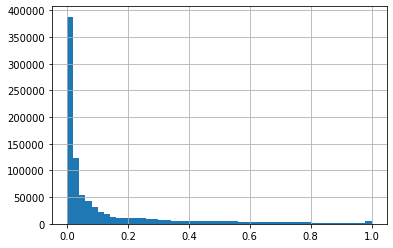

In [6]:
df['p'].hist(bins=50)

plt.savefig(fig_path / 'hist_p_multiseed.pdf')

Compute performance metrics across all cross-validation folds:

In [7]:
y_test = df['GT'].values
y_prob = df['p'].values
y_pred = (y_prob > 0.5).astype(int)

{
    'Acc': np.round(accuracy_score(y_test, y_pred), 4),
    'BAC': np.round(balanced_accuracy_score(y_test, y_pred), 4),
    'Precision': np.round(precision_score(y_test, y_pred), 4),
    'Recall': np.round(recall_score(y_test, y_pred), 4),
    'PR-AUC': np.round(average_precision_score(y_test, y_prob), 4),
    'AUC': np.round(roc_auc_score(y_test, y_prob), 4),
}

{'Acc': 0.9241,
 'BAC': 0.8905,
 'Precision': 0.114,
 'Recall': 0.8562,
 'PR-AUC': 0.5257,
 'AUC': 0.957}

Plot confusion matrix, with probability threshold for link prediction = 0.5:

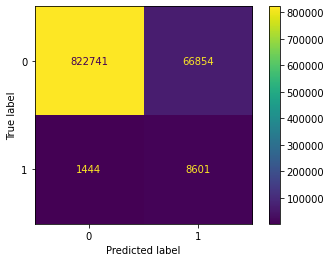

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.savefig(fig_path / 'cm_050_multiseed.pdf')

Plot confusion matrix, with probability threshold for link prediction = 0.9:

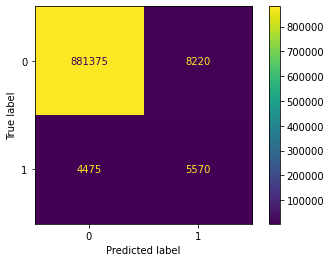

In [9]:
cm = confusion_matrix(y_test, (y_prob > 0.9).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.savefig(fig_path / 'cm_090_multiseed.pdf')

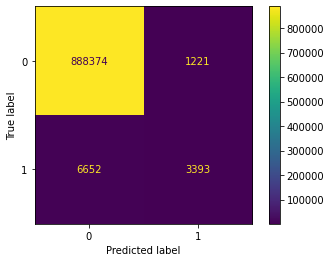

In [10]:
cm = confusion_matrix(y_test, (y_prob > 0.99).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.savefig(fig_path / 'cm_099_multiseed.pdf')

Split dataframe into known (`df_o`) and unknown (`df_n`) links:

In [11]:
df_o = df[df['GT'] == 1].copy()
df_o

,Gen,Phn,p,GT
134,A2M,HumAge,0.853053,1
151,A4GNT,D1071,0.558520,1
218,AAAS,C1052,0.089551,1
423,AAK1,HumCel,0.600397,1
943,AASDH,D1071,0.564206,1
...,...,...,...,...
897742,ZSWIM8,D1351,0.510250,1
897756,ZSWIM8,D1595,0.552730,1
897811,ZSWIM8-AS1,D1320,0.756519,1
897814,ZSWIM8-AS1,D1351,0.812818,1


For unknown links also compute the hits at both thresholds (0.5 and 0.9):

In [12]:
df_n = df[df['GT'] == 0].copy()
df_n['h.50'] = (df_n['p'] > 0.50).astype(int)
df_n['h.90'] = (df_n['p'] > 0.90).astype(int)
df_n['h.99'] = (df_n['p'] > 0.99).astype(int)
df_n

,Gen,Phn,p,GT,h.50,h.90,h.99
0,A1CF,C1007,0.087234,0,0,0,0
1,A1CF,C1010,0.035111,0,0,0,0
2,A1CF,C1052,0.070773,0,0,0,0
3,A1CF,C1067,0.016427,0,0,0,0
4,A1CF,C1068,0.016052,0,0,0,0
...,...,...,...,...,...,...,...
899635,sep-15,L2003,0.001718,0,0,0,0
899636,sep-15,L2004,0.001608,0,0,0,0
899637,sep-15,L2005,0.003763,0,0,0,0
899638,sep-15,L2006,0.002171,0,0,0,0


Count the number of known links per phenotype:

In [13]:
df_o['Phn'].value_counts()

D1071    1105
D1251    1022
D1249    1003
D1075     752
D1536     494
         ... 
D1304       3
D1074       3
D1154       1
D1280       1
D1095       1
Name: Phn, Length: 72, dtype: int64

Count the number of predicted unknown links per phenotype:

In [14]:
df_n.groupby('Phn')[['h.50', 'h.90', 'h.99']].agg('sum').reset_index()

,Phn,h.50,h.90,h.99
0,C1007,2,0,0
1,C1010,555,13,0
2,C1052,1,0,0
3,C1067,427,42,0
4,C1068,503,18,0
...,...,...,...,...
67,L2003,553,1,0
68,L2004,317,1,0
69,L2005,613,3,1
70,L2006,290,1,0


In [15]:
counts = df_n.groupby('Phn')[['h.50', 'h.90', 'h.99']].agg('sum')
counts = counts.merge(df_o['Phn'].value_counts().to_frame(), left_index=True, right_index=True)
counts = counts.rename(columns={'Phn': '# of known edges'})
counts = counts[['# of known edges', 'h.50', 'h.90', 'h.99']]
counts = counts.sort_values('# of known edges', ascending=False)

print(counts.to_string())

        # of known edges  h.50  h.90  h.99
D1071               1105  6925   587     2
D1251               1022  2422   204    22
D1249               1003  2278   177    11
D1075                752  1413   238    12
D1536                494  2950   367     0
D1250                482  1149   278    21
D1416                396  1181   289    53
D1245                372  1494   462   202
D1153                369  1176   311    77
ModDRm               334  8679  1161   119
HumAge               307  7691   786    50
D1524                295  1135   356   154
HumCel               279  7547   766    53
D1155                263  1118   361   159
D1284                259  1124   362   135
D1526                221  1799   351     0
D1269                157  1091   347   142
C1010                153   555    13     0
C1068                115   503    18     0
D1523                111   962   318     7
C1069                110   482    16     0
D1085                 87   375     1     0
D1112      

Create dataframe containing probability matrix of predicted link probability between genes and phenotypes:

In [16]:
rows = []

for gene in tqdm(genes):
    row = []
    
    ds = df[df['Gen'] == gene]
    
    for phenotype in phenotypes:
        dx = ds[ds['Phn'] == phenotype]
        
        assert len(dx) == 1
        
        if dx['GT'].iloc[0] == 1:
            row.append(np.nan)
        else:
            row.append(dx['p'].iloc[0])
    
    rows.append(row)

dm = pd.DataFrame(rows, columns=phenotypes)
dm

  0%|          | 0/12495 [00:00<?, ?it/s]

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1351,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222
0,NaN,0.218909,NaN,0.995783,0.995162,0.904267,0.195878,NaN,NaN,NaN,...,0.713707,0.741539,0.131475,0.153412,0.144044,0.596016,0.017919,0.125731,0.014544,0.113318
1,NaN,0.462202,NaN,0.995604,0.993824,0.843145,0.455014,NaN,NaN,NaN,...,0.604597,0.587960,0.087385,0.095902,0.083078,0.415444,0.009293,0.108571,0.010830,0.082436
2,NaN,0.230765,0.980704,0.999039,0.999319,0.928398,0.210869,NaN,NaN,NaN,...,0.769983,0.706681,0.122290,0.140728,0.140453,0.571639,0.029880,0.149901,0.014590,0.082704
3,NaN,0.260781,0.959155,NaN,NaN,0.909647,0.236014,0.900762,0.948880,0.940003,...,0.633921,0.641107,0.083736,0.074362,0.073202,0.503368,0.010401,0.107555,0.012956,0.084257
4,NaN,0.163861,NaN,0.983399,0.973446,0.768451,0.175621,0.873591,0.899311,0.892870,...,0.589308,0.591907,0.075242,0.078528,0.096766,0.374217,0.012014,0.093177,0.014010,0.096690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,0.607943,NaN,0.409655,0.371486,0.343238,0.319079,0.657504,0.034879,0.024830,0.033264,...,0.015928,0.014162,0.003178,0.019396,0.014703,0.050083,0.005359,0.039946,0.010124,0.012059
12491,0.612463,NaN,0.412180,0.356113,0.361091,0.302517,0.640169,0.032835,0.017642,0.027723,...,0.010944,0.010464,0.002728,0.022733,0.010374,0.057909,0.006751,0.043481,0.012763,0.006226
12492,0.620899,NaN,0.420635,0.351810,0.335535,0.302368,0.625032,0.021512,0.020388,0.028371,...,0.011544,0.013753,0.004140,0.019663,0.008914,0.048338,0.006392,0.039671,0.011423,0.007578
12493,0.594562,NaN,0.416375,0.375788,0.354185,0.289671,0.638576,0.025269,0.017926,0.020390,...,0.014970,0.015901,0.003012,0.019047,0.012569,0.057867,0.007349,0.037109,0.015066,0.009997


Add information about the sum of predicted probabilities for each gene:

In [17]:
dm.index = genes
dm['Total'] = dm[phenotypes].sum(axis=1)
dm = dm.sort_values('Total', ascending=False)
dm

,D1071,HumCel,D1536,D1251,D1249,D1526,ModDRm,D1091,D1092,D1082,...,D1595,D1154,D1218,D1304,D1094,D1280,D1518,D1095,D1222,Total
L2007,0.872716,0.115986,0.881611,0.758536,0.773274,0.513997,0.074190,0.988443,0.993968,0.989023,...,0.807774,0.168961,0.209367,0.271417,0.609982,0.080530,0.167195,0.056621,0.169042,46.926446
MAP3K4-AS1,NaN,0.218909,NaN,0.995783,0.995162,0.904267,0.195878,NaN,NaN,NaN,...,0.741539,0.131475,0.153412,0.144044,0.596016,0.017919,0.125731,0.014544,0.113318,39.728291
RPL21P116,0.899385,0.121645,0.859769,0.942021,0.928760,0.657513,0.085674,0.943490,0.959702,0.936026,...,0.644068,0.110666,0.153963,0.096301,0.375612,0.021549,0.122799,0.026297,0.120541,39.694761
ADAMTS7,0.912031,0.139473,0.863343,0.902576,0.953481,0.655261,0.076847,0.955775,0.957155,0.942669,...,0.704118,0.094819,0.144008,0.146199,0.544325,0.024406,0.086294,0.019748,0.080433,39.629527
RNU6-415P,0.894530,0.101749,0.870581,0.915637,0.908173,0.651312,0.090118,0.945115,0.950856,0.939534,...,0.640098,0.132342,0.109684,0.122262,0.468086,0.019257,0.104102,0.018418,0.097618,39.435275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOD2,0.530130,0.684167,0.324078,0.270900,0.245531,0.224237,NaN,0.013797,0.009117,0.008893,...,0.008169,0.003447,0.018283,0.005815,0.033538,0.001467,0.035569,0.010774,0.010637,3.524534
RPL3L,0.410488,0.351482,0.279830,0.236945,0.216139,0.176823,0.392424,0.012080,0.008774,0.011033,...,0.005702,0.003678,0.020196,0.011853,0.026653,0.009727,0.019125,0.005955,0.006595,3.502550
MYO16,0.324103,0.290901,0.213359,0.199475,0.189116,0.149175,0.367289,0.021763,0.022457,0.013676,...,0.021742,0.006090,0.017566,0.017793,0.046707,0.023863,0.018678,0.032485,0.009193,3.474151
COQ7,0.517276,0.655378,0.315771,0.267034,0.253365,0.219518,NaN,0.014584,0.010372,0.009709,...,0.004491,0.002280,0.010746,0.005308,0.037660,0.001537,0.035156,0.010791,0.011241,3.455827


Show the sum of predicted probabilities for each phenotype:

In [18]:
print(dm[phenotypes].sum(axis=0).to_string())

D1071     6660.280368
HumCel    7086.560866
D1536     5078.533925
D1251     4358.107682
D1249     4135.849782
D1526     3973.522949
ModDRm    7606.214519
D1091     1024.211725
D1092      996.690460
D1082      987.818203
L2001     1026.682446
L2005      900.040734
D1112     1176.480393
D1111     1013.175278
D1502      484.844122
D1085     1275.136455
D1245     3085.734191
D1075     2500.029141
D1183     1241.870528
D1182     1274.782340
D1156      935.353432
D1248      592.784571
C1007     1391.633282
D1525     1055.412804
HumAge    7185.262911
D1077      940.386976
D1321     1082.483679
C1010     1445.853047
C1068     1150.101263
C1069     1119.312623
D1250     1541.528387
D1416     1502.103361
D1153     1499.365016
D1524     1467.149932
D1269     1488.892882
D1284     1430.514987
D1523     1301.243522
D1537     1083.448578
D1320      968.056090
D1155     1439.693541
L2003      761.739606
D1159     1008.002830
D1268      791.234815
C1080      463.162667
D1073      603.704082
D1076     

Calculate the number of known links for each gene, and compare that with the sum of predicted probabilities of novel ones:

In [19]:
dm['Known'] = dm.isna().sum(axis=1)

In [20]:
print(dm[['Total', 'Known']].iloc[:100].to_string())

                  Total  Known
L2007         46.926446      0
MAP3K4-AS1    39.728291     11
RPL21P116     39.694761      5
ADAMTS7       39.629527      5
RNU6-415P     39.435275      5
NDUFA5P10     39.277551      7
CTSH          39.206359      6
PRKN          38.921199      7
RPS16P9       38.787682      5
LINC01768     38.740444      7
AGPAT4        38.668032      7
UBA52P6       38.357951      7
MIR6088       38.317302     12
POLR1G        38.245881     12
NAA25         38.076808     10
CDKN2B-AS1    37.760554     15
CHRNB4        37.471464      4
LPA           37.420117      8
HNRNPA1P52    37.233338      3
MAP3K4        37.189032     11
ANKRD34C-AS1  37.087817      3
THADA         37.080567      7
RPS2P41       37.054693     11
LINC00567     37.019789      3
PLG           36.985392      8
PPP1R13L      36.898665     12
MC1R          36.896501      6
SLC22A3       36.830686      5
CDKN2A-DT     36.752495      4
EZH2P1        36.736268      3
ACTL10        36.727025      6
ADAM1A  

Plot the histogram of sums of predicted probabilities for all genes:

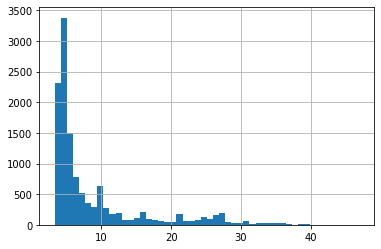

In [21]:
dm['Total'].hist(bins=50)

plt.savefig(fig_path / 'hist_p_sum_per_gene_multiseed.pdf')